In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')

In [3]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, we are using log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

# Encode emp_length into 4 categories: 0-1 year, 2-5 years, 6-10 years, > 10 years
def transform_emp_length(emp_length):
    if emp_length in ["< 1 year", "1 year"]:
        return "0-1 year"
    elif emp_length in ["2 years", "3 years", "4 years", "5 years"]:
        return "2-5 years"
    elif emp_length in ["6 years", "7 years", "8 years", "9 years", "10 years"]:
        return "6-10 years"
    elif emp_length == "10+ years":
        return "> 10 years"
    
X['emp_length'] = X['emp_length'].apply(transform_emp_length)

In [4]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
# dtype=int to get binary (0 or 1) values
X_encoded = pd.get_dummies(X, columns=categorical_columns, dtype=int)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [5]:
# Drop rows with NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Ensure y_train matches X_train, y_test matches X_test
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [6]:
# The data contains 5 times as many repaid loans (0) as defaulted loans (1)
# Such class balance issues can skew predictions greatly
# We can use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Accuracy: 0.66 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.70      0.76     40328
         1.0       0.33      0.55      0.41     11228

    accuracy                           0.66     51556
   macro avg       0.59      0.62      0.59     51556
weighted avg       0.74      0.66      0.69     51556



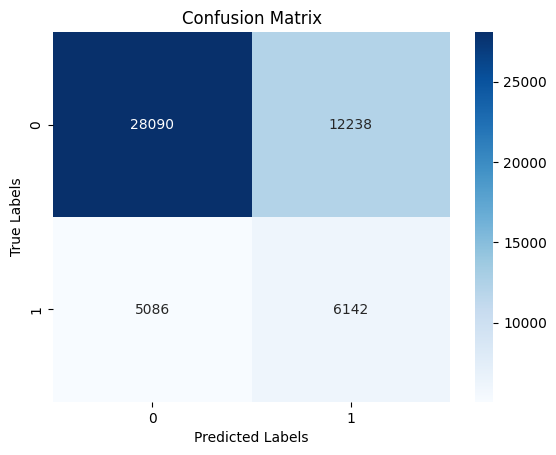

In [11]:
# Using sklearn library to run Logit Regression

# Fit logistic regression model
model = LogisticRegression(solver='liblinear',max_iter=1000)
model.fit(X_train, y_train)

# Making predictions with a decision threshold of 0.3
prob = model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (prob >= threshold).astype(int)

# Generating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()